# Matala 2 - Pandas

In [1]:
#installing pandas libraries
!pip install pandas-datareader  
# for reading files
!pip install --upgrade html5lib==1.0b8  
# for reading html

import pandas as pd #pandas library
from pandas_datareader import data #data readers (google, html, etc.)
#The following line ensures that graphs are rendered in the notebook (and not in another window)
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt #Plotting library
import datetime as dt #datetime for timeseries support
import re

# Q1 - duration_to_next_event

In [2]:
data = pd.read_csv('C:\\Users\\efrat\\OneDrive\\שולחן העבודה\\matala2_cosmetics_2019-Nov.csv')
#convert the 'event_time'
data['event_time'] = pd.to_datetime(data['event_time'])
data[1:10]

C:\Users\efrat\AppData\Local\Temp\ipykernel_22732\4262378510.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:\\Users\\efrat\\OneDrive\\שולחן העבודה\\matala2_cosmetics_2019-Nov.csv')


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1,2019-11-01 00:00:09+00:00,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10+00:00,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11+00:00,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24+00:00,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
5,2019-11-01 00:00:24+00:00,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
6,2019-11-01 00:00:25+00:00,view,5856189,1487580009026551821,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
7,2019-11-01 00:00:32+00:00,view,5837835,1933472286753424063,NaN,NaN,3.49,514649199,432a4e95-375c-4b40-bd36-0fc039e77580
8,2019-11-01 00:00:34+00:00,remove_from_cart,5870838,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
9,2019-11-01 00:00:37+00:00,view,5870803,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a


In [3]:
data = data.sort_values(['user_session', 'event_time'], ascending=[False, True])
grouped_data = data.groupby('user_session')
data['duration_to_next_event'] = (grouped_data['event_time'].shift(-1) - data['event_time']).dt.total_seconds()
data['duration_to_next_event'] = data['duration_to_next_event'].fillna(0)
# data = data.sort_index()
data[1:10]

# Q2 - funnel_number

In [8]:
def assign_funnel_number(data):
    data = data.sort_values(['user_id', 'event_time'])
    time_diff = (data.groupby('user_id')['event_time'].diff().fillna(pd.Timedelta(seconds=0)))
    funnel_num = (time_diff > pd.Timedelta(days=5)).astype(int)
    funnel_num = (funnel_num.groupby(data['user_id']).cumsum().add(1))
    funnel_num.loc[data.groupby('user_id').head(1).index] = 1
    return funnel_num

data['funnel_number'] = assign_funnel_number(data)

# Q3 - index_in_funnel

In [11]:
data['index_in_funnel'] = data.groupby(['user_id', 'funnel_number']).cumcount() + 1
data[1:30]

# Q4 - ReGex

In [12]:
def regex_price(data):
    price_match = re.compile(r'[^\d\.]+') #r means row, \d matches any digits
    valid_prices = data['price'].str.replace(r'[^\d\.]', '').astype(float)
    data['price'] = valid_prices
    return data

data = regex_price(data)

#let's check the type
#type(data['price'][0])

#data[1:30]

C:\Users\efrat\AppData\Local\Temp\ipykernel_22732\1177234052.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  valid_prices = data['price'].str.replace(r'[^\d\.]', '').astype(float)


numpy.float64

# Q5 - chart

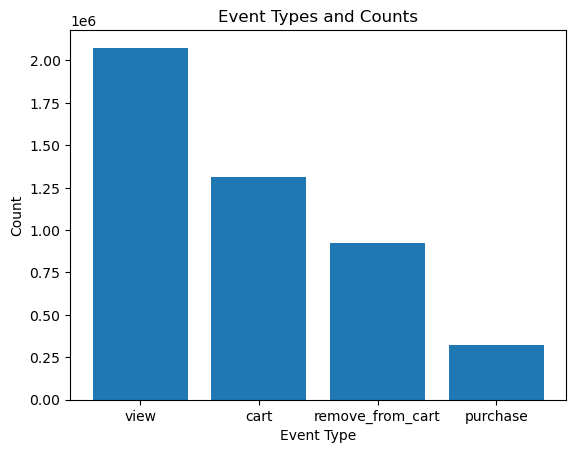

In [13]:
event_counts = data['event_type'].value_counts()

# bar chart of the event types
plt.bar(event_counts.index, event_counts.values)
plt.title('Event Types and Counts')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

In [18]:
data['funnel_number'].value_counts()

1    3574913
2     868473
3     175229
4      16939
5        283
Name: funnel_number, dtype: int64

# Q6 - Session data

In [19]:
session_data = data.groupby(['user_session']).agg({
    "user_id" : 'first',
    'funnel_number' : 'first',
    'index_in_funnel' : 'first',
    "duration_to_next_event" : lambda x: list(x),
    'event_type' : lambda x: list(x),
    'product_id' :lambda x: list(x),
})

#let's define next columns in order to continue.
session_data['event_count'] = session_data['duration_to_next_event'].apply(len) #e
session_data['event_sum'] = session_data['duration_to_next_event'].apply(sum) #f


#g
def viewed_products(row):
    lst = []
    for i in range(len(row['event_type'])):
        if row['event_type'][i] == "view":
            lst.append(row['product_id'][i])
    return lst

session_data['list_of_viewed'] = session_data.apply(viewed_products, axis=1)

#h
def cart_products(row):
    lst = []
    for i in range(len(row['event_type'])):
        if row['event_type'][i] == "cart":
            lst.append(row['product_id'][i])
    return lst

session_data['list_of_added_to_cart '] = session_data.apply(cart_products, axis=1)

#i
def purchase_products(row):
    lst = []
    for i in range(len(row['event_type'])):
        if row['event_type'][i] == "purchase":
            lst.append(row['product_id'][i])
    return lst

session_data['list_of_purchased'] = session_data.apply(purchase_products, axis=1)


session_data[1:20]

,user_id,funnel_number,index_in_funnel,duration_to_next_event,event_type,product_id,event_count,event_sum,list_of_viewed,list_of_added_to_cart,list_of_purchased
user_session,,,,,,,,,,,
00001bc6-1e04-4861-be5d-1bc73929c21a,570103701,1,2,[0.0],[view],[5771614],1,0.0,[5771614],[],[]
00001e77-5db8-4e96-ab7a-022ed3caf8b3,571677620,1,1,[0.0],[view],[5568472],1,0.0,[5568472],[],[]
00004c7d-9507-474e-a559-0fdaccaaa390,504468592,2,402,[0.0],[view],[5864850],1,0.0,[5864850],[],[]
0000597b-de39-4a77-9fe5-02c8792ca14e,571211128,1,2,"[56.0, 95.0, 0.0]","[view, view, view]","[5861620, 5861619, 5861591]",3,151.0,"[5861620, 5861619, 5861591]",[],[]
00005ac0-5c22-4756-bb12-31b90af75fa3,473600495,1,1,"[11.0, 0.0]","[view, view]","[5846437, 5846436]",2,11.0,"[5846437, 5846436]",[],[]
0000645a-8160-4a3d-91bf-154bff0a22e3,530580938,1,5,"[287.0, 0.0]","[view, view]","[5847576, 5769929]",2,287.0,"[5847576, 5769929]",[],[]
0000763c-7baf-45fd-aad3-ca2076aea17d,375765155,2,5,[0.0],[view],[5849879],1,0.0,[5849879],[],[]
00007819-3646-099d-f895-f36bb77191c9,563291665,1,13,"[132.0, 64.0, 63.0, 0.0]","[view, view, view, view]","[5783987, 5591314, 5772167, 5806922]",4,259.0,"[5783987, 5591314, 5772167, 5806922]",[],[]
00008a21-4711-4dec-b8bc-ca7caeb9d41a,578037977,1,10,[0.0],[view],[5829068],1,0.0,[5829068],[],[]
